# Knowledge distillation

In [1]:
from typing import Callable, Union
from collections import namedtuple
from copy import deepcopy
import numpy as np
import torch
from torch import nn
from torchtext.data.utils import get_tokenizer
import torchtext.vocab as tvcb
from torchtext.datasets import SST2
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt

Будем рассматривать задачу *Sentiment analysis*, используя датасет `SST2`. В качестве модели-учителя возьмём BiLSTM, использованный в статье [Distilling Task-Specific Knowledge from BERT into Simple Neural Networks](https://arxiv.org/abs/1903.12136), в качестве модели-ученика -- более простую рекуррентную нейронную сеть.

Функция для получения словаря (слово -> токен) и матрицы эмбеддингов (токен -> вектор) с помощью исходного датасета, токенизатора и предобученных эмбеддингов.

In [2]:
def get_vocab_embeddings(dataset: Dataset,
                         tokenizer: Callable,
                         vectors: tvcb.Vectors
                         ) -> tuple[tvcb.Vocab, np.ndarray]:
    def yield_tokens(data_iter):
        for text, _ in data_iter:
            yield tokenizer(text)

    vocab = tvcb.build_vocab_from_iterator(yield_tokens(dataset),
                                           specials=['<unk>'])
    vocab.set_default_index(vocab['<unk>'])

    embeddings = np.zeros((len(vocab), vectors.dim))
    for i, word in enumerate(vocab.get_itos()):
        embeddings[i] = vectors[word]

    return vocab, embeddings

Вспомогательный `namedtuple` и функция для визуализации процесса обучения.

In [3]:
TrainResult = namedtuple('TrainResult', ('train_loss', 'train_acc', 'val_loss', 'val_acc'))

def display_results(r: TrainResult):
    print('Accuracy:')
    print(f'  best: {max(r.val_acc)*100:.1f}%')
    print(f'  at min loss: {(r.val_acc[np.argmin(r.val_loss)])*100:.1f}%')

    fig, [ax1, ax2] = plt.subplots(ncols=2)
    fig.set_size_inches(12.0, 4.0)
    fig.subplots_adjust(left=0.07, right=0.97, bottom=0.15, top=0.95)
    epochs = np.arange(1, len(r.train_loss) + 1)
    ax1.plot(epochs, r.train_loss, label='train')
    ax1.plot(epochs, r.val_loss, label='validate')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax2.plot(epochs, r.train_acc*100, label='train')
    ax2.plot(epochs, r.val_acc*100, label='validate')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    return fig, [ax1, ax2]

Класс для создания бинарного классификатора текстов на основе рекуррентных блоков. Позволяет как обучать эмбеддинги, так и использовать предобученные. Метод `text_to_tensor` преобразует набор текстов в тензор из токенов с паддингом, а также переставляет эти тексты вместе с соответствующими бинарными метками в порядке убывания. Это позволяет использовать `PackedSequence` в методе `forward`, что ускоряет обучение и позволяет избежать затухания сигнала из-за пропускания через RNN `<pad>`.

In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, tokenizer: Callable, vocab: tvcb.Vocab,
                 input_size: int, hidden_size: Union[int, None] = None,
                 embeddings: Union[np.ndarray, torch.tensor, None] = None,
                 rnn: str = 'LSTM', lstm_bidirectional: bool = False,
                 rnn_linear_dim: Union[int, None] = None):
        super().__init__()
        assert embeddings is None or input_size == embeddings.shape[1]
        self.input_size = input_size
        if hidden_size is None:
            hidden_size = self.input_size
        self.hidden_size = hidden_size

        # text processing tools
        self.tokenizer = tokenizer
        self.vocab = vocab
        if embeddings is None:
            self.embedding = nn.Embedding(
                len(vocab), hidden_size, padding_idx=0
            )
        else:
            if isinstance(embeddings, np.ndarray):
                embeddings = torch.tensor(embeddings).float()
            self.embedding = nn.Embedding.from_pretrained(
                embeddings=embeddings,
                freeze=True
            )

        # recurrent block
        rnn_settings = dict(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            batch_first=True,
        )
        self.rnn_type = rnn
        self.is_bidirectional = False  # defines rnn "output" size
        if rnn == 'LSTM':
            rnn_module = nn.LSTM
            if lstm_bidirectional:
                rnn_settings['bidirectional'] = lstm_bidirectional
                self.is_bidirectional = True
        elif rnn == 'RNN':
            rnn_module = nn.RNN
        elif rnn == 'GRU':
            rnn_module = nn.GRU
        else:
            raise ValueError(f'Unrecoginezed RNN type {rnn}')
        self.rnn = rnn_module(**rnn_settings)

        # linear layers after RNN
        if self.rnn_type == 'LSTM' and lstm_bidirectional:
            in_features = hidden_size * 2
        else:
            in_features = hidden_size
        if rnn_linear_dim is None:
            rnn_linear_dim = in_features
        self.stack = nn.Sequential(
            nn.Linear(in_features, rnn_linear_dim),
            nn.ReLU(),
            nn.Linear(rnn_linear_dim, 1)  # binary classifier
        )

    def forward(self, X: torch.tensor, lengths: torch.tensor):
        X = self.embedding(X)
        X = pack_padded_sequence(X, lengths, batch_first=True,
                                 enforce_sorted=False)
        _, hidden = self.rnn(X)
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]
            if self.is_bidirectional:
                hidden = torch.cat((hidden[0], hidden[1]), axis=1)
        logits = self.stack(hidden)
        return logits.squeeze()

    def text_to_tensor(self, texts: tuple[str], labels: torch.tensor
                       ) -> tuple[torch.tensor, torch.tensor, torch.tensor]:
        tokens = [self.vocab(self.tokenizer(text)) for text in texts]
        lengths = torch.tensor([len(token_list) for token_list in tokens],
                               dtype=torch.int64)
        lengths, perm_inds = lengths.sort(0, descending=True)
        max_length = lengths[0].item()
        tokens_arr = np.zeros((len(tokens), max_length), dtype='int64')
        for i, ind in enumerate(perm_inds):
            j = len(tokens[ind])
            tokens_arr[i, :j] = np.asarray(tokens[ind])
        X = torch.tensor(tokens_arr)
        y = labels[perm_inds]
        return X, y, lengths

При обучении будем сохранять параметры модели с минимальными потерями или максимальной точностью на валидационной выборке.

In [5]:
def train(model: RNNClassifier, train_dataloader: DataLoader,
          val_dataloader: DataLoader, device: torch.device, 
          optimizer: torch.optim.Optimizer, epochs: int,
          load_best: bool = True, use_acc: bool = False
          ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    train_acc = np.zeros(epochs)
    train_loss = np.zeros_like(train_acc)
    val_acc = np.zeros_like(train_acc)
    val_loss = np.ones_like(train_acc) * np.inf
    if load_best:
        state_dict_best = deepcopy(model.state_dict())

    loss_function = nn.BCEWithLogitsLoss()
    for i in tqdm(range(epochs)):
        # train loop
        model.train()
        hits = 0   # accurate predictions
        total = 0  # number of input texts
        for texts, labels in train_dataloader:
            # transform text to tensor of tokens with padding
            X, y, lengths = model.text_to_tensor(texts, labels)
            X, y = X.to(device), y.to(device)

            # run forward loop
            logits = model(X, lengths)
            loss = loss_function(logits, y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update accuracy and loss
            hits += accurate_predictions(logits.detach(), y)
            total += len(y)
            train_loss[i] += loss.item() * len(y)  # avg loss per sample

        train_acc[i] = hits / total
        train_loss[i] /= total

        # validation
        val_loss[i], val_acc[i] = evaluate(model, val_dataloader, device)

        if load_best:
            best_ind = np.argmax(val_acc) if use_acc else np.argmin(val_loss)
            if best_ind == i:
                state_dict_best = deepcopy(model.state_dict())

    if load_best:
        model.load_state_dict(state_dict_best)

    return TrainResult(train_loss, train_acc, val_loss, val_acc)


@torch.no_grad()
def evaluate(model: RNNClassifier, dataloader: DataLoader, device: torch.device
             ) -> tuple[float, float]:
    model.eval()
    hits, total = 0, 0
    total_loss = 0.0
    loss_function = nn.BCEWithLogitsLoss()

    for texts, labels in dataloader:
        X, y, lengths = model.text_to_tensor(texts, labels)
        X, y = X.to(device), y.to(device)
        logits = model(X, lengths)
        total_loss += loss_function(logits, y.float()).item() * len(y)
        hits += accurate_predictions(logits, y)
        total += len(y)

    return total_loss / total, hits / total


def accurate_predictions(logits: torch.tensor,
                         true_labels: torch.tensor) -> int:
    predictions = torch.round(torch.sigmoid(logits)).int()
    return (predictions == true_labels).sum().item()


In [6]:
# load datasets
train_dataset = SST2(split='train')
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataset = SST2(split='dev')
val_dataloader = DataLoader(val_dataset, batch_size=1024)

# select device and tokenizer (shared between models)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = get_tokenizer('basic_english')

/home/vsg/virtualenvs/torch/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/vsg/virtualenvs/torch/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/selecting.py:54: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn("Lambda function is not supported for pickle, please use "


## Учитель

Будем использовать BiLSTM с 300-мерными эмбеддингами GloVe.

100%|███████████████████████████████████████████| 20/20 [01:44<00:00,  5.22s/it]

Accuracy:
  best: 85.6%
  at min loss: 84.5%


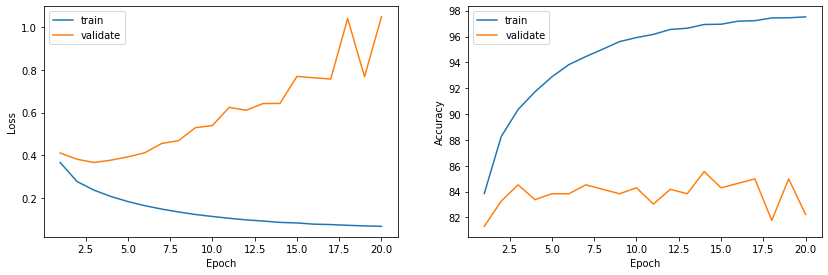

In [7]:
vocab, embeddings = get_vocab_embeddings(
    dataset=train_dataset,
    tokenizer=tokenizer,
    vectors=tvcb.GloVe('840B', dim=300)
)
teacher = RNNClassifier(
    tokenizer=tokenizer,
    vocab=vocab,
    input_size=300,
    hidden_size=300,
    embeddings=embeddings,
    rnn='LSTM',
    lstm_bidirectional=False,
    rnn_linear_dim=400
)
teacher.to(device)
optimizer = torch.optim.Adadelta(teacher.parameters(), weight_decay=1e-4)
teacher_results = train(teacher, train_dataloader, val_dataloader, device,
                        optimizer, epochs=20, load_best=True, use_acc=True)
fig, axes = display_results(teacher_results)

## Ученик

Существенно сократим размер модели, перейдя к 50-мерным эмбеддингам и обычной RNN с меньшей размерностью скрытого состояния.

100%|█████████████████████████████████████████| 100/100 [06:59<00:00,  4.20s/it]

Accuracy:
  best: 76.7%
  at min loss: 73.3%


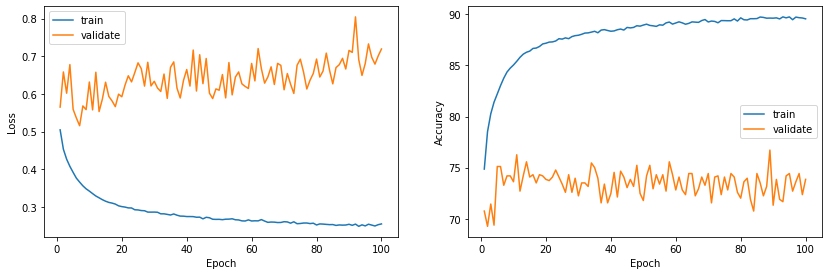

In [8]:
vocab, embeddings = get_vocab_embeddings(
    dataset=train_dataset,
    tokenizer=tokenizer,
    vectors=tvcb.GloVe('6B', dim=50)
)
student = RNNClassifier(
    tokenizer=tokenizer,
    vocab=vocab,
    input_size=50,
    hidden_size=40,
    embeddings=embeddings,
    rnn='RNN',
    rnn_linear_dim=80
)
student.to(device)
initial_params = deepcopy(student.state_dict())
optimizer = torch.optim.Adadelta(student.parameters(), weight_decay=1e-5)
student_results = train(student, train_dataloader, val_dataloader, device,
                        optimizer, epochs=100, load_best=True)
fig, axes = display_results(student_results)

## Дистилляция

Немного скорректируем процесс обучения, добавив к потерям `MSE` между выходами ученика и учителя с весом `1 - alpha`.

In [9]:
def distill(student: RNNClassifier, teacher: RNNClassifier,
            train_dataloader: DataLoader, val_dataloader: DataLoader,
            device: torch.device, optimizer: torch.optim.Optimizer,
            alpha: float = 0.5, epochs: int = 50,
            load_best: bool = True, use_acc: bool = False,
            ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    train_acc = np.zeros(epochs)
    train_loss = np.zeros_like(train_acc)
    val_acc = np.zeros_like(train_acc)
    val_loss = np.ones_like(train_acc) * np.inf
    if load_best:
        state_dict_best = deepcopy(student.state_dict())

    ce_lf = nn.BCEWithLogitsLoss()
    dist_lf = nn.MSELoss()
    teacher.eval()

    for i in tqdm(range(epochs)):
        hits, total = 0, 0
        for texts, labels in train_dataloader:
            # evaluate teacher for logit targets
            with torch.no_grad():
                X, y_t, lengths = teacher.text_to_tensor(texts, labels)
                target_logits = teacher(X.to(device), lengths)

            # train student
            student.train()
            X, y, lengths = student.text_to_tensor(texts, labels)
            assert (y == y_t).all()
            y = y.to(device)
            logits = student(X.to(device), lengths)
            ce_loss = ce_lf(logits, y.float())
            dist_loss = dist_lf(logits, target_logits)
            loss = alpha * ce_loss + (1 - alpha) * dist_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update accuracy and loss
            hits += accurate_predictions(logits.detach(), y)
            total += len(y)
            train_loss[i] += loss.item() * len(y)

        train_acc[i] = hits / total
        train_loss[i] /= total

        # evaluate student
        student.eval()
        val_loss[i] = 0.0
        with torch.no_grad():
            total = 0
            for texts, labels in val_dataloader:
                X, y_t, lengths = teacher.text_to_tensor(texts, labels)
                target_logits = teacher(X.to(device), lengths)
                X, y, lengths = student.text_to_tensor(texts, labels)
                assert (y == y_t).all()
                X, y = X.to(device), y.to(device)
                logits = student(X, lengths)
                val_loss[i] += (ce_lf(logits, y.float()).item()
                                * alpha * len(y))
                val_loss[i] += (dist_lf(logits, target_logits).item()
                                * (1 - alpha) * len(y))
                val_acc[i] += accurate_predictions(logits, y)
                total += len(y)

        val_acc[i] /= total
        val_loss[i] /= total

        if load_best:
            best_ind = np.argmax(val_acc) if use_acc else np.argmin(val_loss)
            if best_ind == i:
                state_dict_best = deepcopy(student.state_dict())

    if load_best:
        student.load_state_dict(state_dict_best)

    return TrainResult(train_loss, train_acc, val_loss, val_acc)

100%|█████████████████████████████████████████| 100/100 [09:50<00:00,  5.91s/it]

Accuracy:
  best: 78.8%
  at min loss: 77.5%


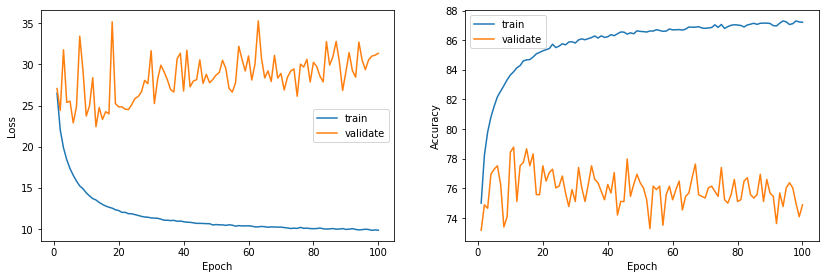

In [10]:
student.load_state_dict(initial_params)  # reset weights
optimizer = torch.optim.Adadelta(student.parameters(), weight_decay=1e-5)
distill_results = distill(
    student, teacher, train_dataloader, val_dataloader, device,
    optimizer, alpha=0.5, epochs=100, load_best=True)
fig, axes = display_results(distill_results)

Результаты немного улучшились, видно, что наличие сети-учителя препятствует переобучению.